In [2]:
import pandas as pd

# Load datasets (replace 'dataset1.csv' and 'dataset2.csv' with your actual file paths)
dataset1 = pd.read_csv('l2-benign.csv')
dataset2 = pd.read_csv('l2-malicious.csv')

# Display the first 5 rows of dataset1
print("Head of l2-benign.csv:")
print(dataset1.head())

# Display the first 5 rows of dataset2
print("Head of l2-malicious.csv:")
print(dataset2.head())

Head of l2-benign.csv:
          SourceIP    DestinationIP  SourcePort  DestinationPort  \
0   192.168.20.191  176.103.130.131       50749              443   
1   192.168.20.191  176.103.130.131       50749              443   
2   192.168.20.191  176.103.130.131       50749              443   
3   192.168.20.191  176.103.130.131       50749              443   
4  176.103.130.131   192.168.20.191         443            50749   

             TimeStamp    Duration  FlowBytesSent  FlowSentRate  \
0  2020-01-14 15:49:11   95.081550          62311    655.342703   
1  2020-01-14 15:50:52  122.309318          93828    767.136973   
2  2020-01-14 15:52:55  120.958413          38784    320.639127   
3  2020-01-14 15:54:56  110.501080          61993    561.017141   
4  2020-01-14 15:56:46   54.229891          83641   1542.341289   

   FlowBytesReceived  FlowReceivedRate  ...  PacketTimeCoefficientofVariation  \
0              65358        687.388878  ...                          0.574626   
1  

Correlation Matrix:
                                        Duration  FlowBytesSent  FlowSentRate  \
Duration                                1.000000       0.416264      0.045125   
FlowBytesSent                           0.416264       1.000000      0.005320   
FlowSentRate                            0.045125       0.005320      1.000000   
FlowBytesReceived                       0.404750       0.801984      0.007533   
FlowReceivedRate                        0.068780       0.008445      0.917661   
PacketLengthVariance                    0.557257       0.272263      0.031860   
PacketLengthStandardDeviation           0.624055       0.307815      0.048554   
PacketLengthMean                        0.506936       0.189041      0.051855   
PacketLengthMedian                      0.380619       0.292418      0.005199   
PacketLengthMode                        0.014125       0.011645      0.033120   
PacketLengthSkewFromMedian              0.225366       0.000228      0.012390   
PacketLe

C:\Users\test\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\test\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00      7499

    accuracy                           1.00      8090
   macro avg       1.00      1.00      1.00      8090
weighted avg       1.00      1.00      1.00      8090

Confusion Matrix:
[[ 590    1]
 [   0 7499]]
False Negatives: 0
False Positives: 1
Number of Features Selected: 14
Accuracy Score: 0.999876390605686


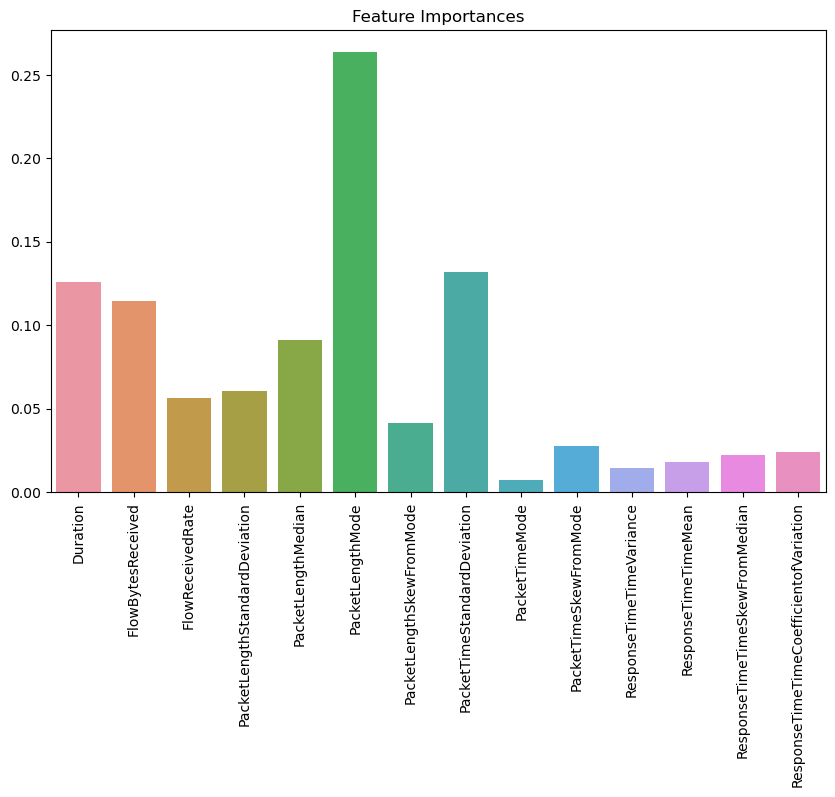

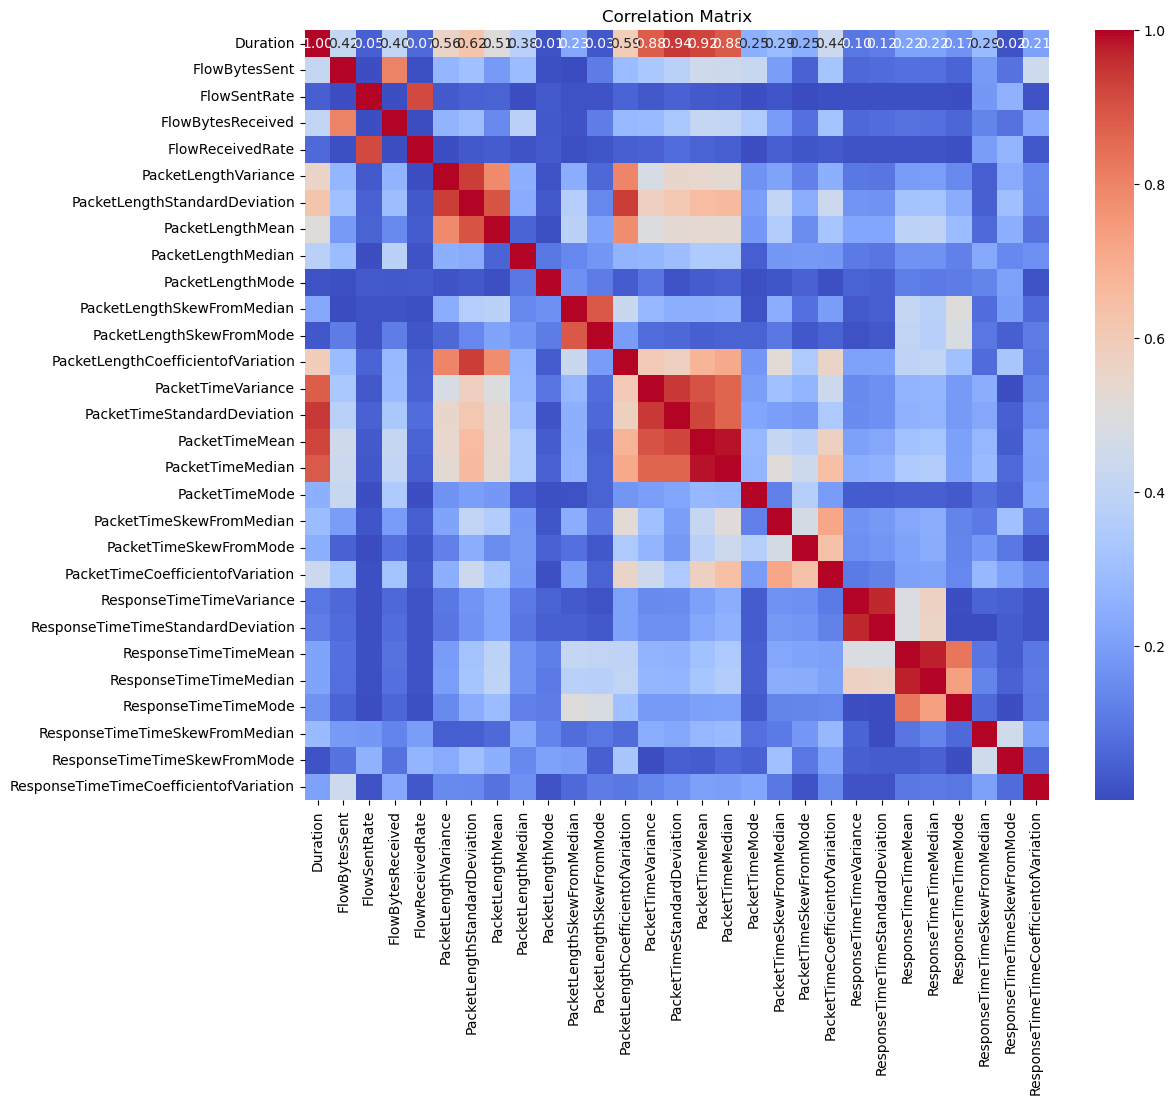

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms

# Load datasets
df_benign = pd.read_csv('l2-benign.csv')
df_malicious = pd.read_csv('l2-malicious.csv')

# Combine datasets
df = pd.concat([df_benign, df_malicious])

# Drop non-relevant columns
df = df.drop(columns=['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp'])

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Sample a subset of the dataset
df_sampled = df.sample(frac=0.1, random_state=42)

# Separate features and labels
X = df_sampled.drop(columns=['Label'])
y = df_sampled['Label']

# Compute the correlation matrix and remove highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X = X.drop(columns=to_drop)

# Display the correlation matrix and features to drop
print("Correlation Matrix:")
print(corr_matrix)
print("\nFeatures to drop due to high correlation:")
for feature in to_drop:
    print(f"{feature}: {max(upper[feature])}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define genetic algorithm parameters
def evaluate(individual):
    mask = np.array(individual, dtype=bool)
    X_train_selected = X_train.loc[:, mask]
    X_test_selected = X_test.loc[:, mask]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    return (accuracy_score(y_test, y_pred),)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X_train.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Genetic Algorithm
population = toolbox.population(n=50)
ngen = 40
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

# Select best individual
best_individual = tools.selBest(population, 1)[0]
mask = np.array(best_individual, dtype=bool)
X_train_selected = X_train.loc[:, mask]
X_test_selected = X_test.loc[:, mask]

# Train and evaluate model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Results
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

tn, fp, fn, tp = conf_matrix.ravel()
print(f"False Negatives: {fn}")
print(f"False Positives: {fp}")
print(f"Number of Features Selected: {sum(mask)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

# Feature Importance Graph
selected_features = X_train.columns[mask]
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_features, y=model.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
